### Semi-supervised learning
## Multi-tasking 
Data taken from https://www.kaggle.com/datasets/prathamgrover/3d-liver-segmentation?resource=download'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import os
import sys
import glob
import itertools
from pathlib import Path
cd= Path.cwd().parent
sys.path.append(str(cd))

from func.utill import visualize_slices, DiceLoss



In [2]:

def check_nii_sizes(folder_path):
    nii_files = glob.glob(os.path.join(folder_path, "*.nii"))
    for file in nii_files:
        img = nib.load(file)
        data = img.get_fdata()
        print(f"File: {os.path.basename(file)}, Shape: {data.shape}")

In [3]:

INPUT_SHAPE = (64, 64, 64) # ( D, H, W)
NUM_CLASSES = 3  # Background, Segment 1, Segment 2
LATENT_DIM = 256 # RNN batch
BATCH_SIZE = 4
TIME_STEPS = 10 # Time series size 


class ConvBlock(nn.Module):
    """
    A 3D Convolutional block: Conv3D -> BatchNorm -> ReLU
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Seg_decoder(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.up_seg1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2) # -> 64x14x14x14
        self.dec_seg1 = ConvBlock(128, 64) # add skip connection 64+64= 128
        
        self.up_seg2 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2) # 32x28x28x28
        self.dec_seg2 = ConvBlock(64, 32) # add skip connection 32+32= 64
        
        self.out_seg = nn.Conv3d(32, num_classes, kernel_size=1) # Output segmentation
        
    def forward(self, b , s1, s2):
         # segmentation decoder forward step
        us1 = self.up_seg1(b) # -> Bx64x14x14x14
        ds1 = self.dec_seg1(torch.cat([us1, s2], dim=1)) # Concat skip 2
        
        us2 = self.up_seg2(ds1) # -> Bx32x28x28x28
        ds2 = self.dec_seg2(torch.cat([us2, s1], dim=1)) # Concat skip 1
        us3 = self.out_seg(ds2) 
        return us3
    
class Recon_decoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.up_recon1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2) # ->64x14x14x14
        self.dec_recon1 = ConvBlock(128, 64)

        self.up_recon2 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2) # -> 32x28x28x28
        self.dec_recon2 = ConvBlock(64, 32)

        self.out_recon = nn.Sequential(
            nn.Conv3d(32, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, b, s1, s2):
        ur1 = self.up_recon1(b)   # -> Bx64x14x14x14
        dr1 = self.dec_recon1(torch.cat([ur1, s2], dim=1))
        
        ur2 = self.up_recon2(dr1) # -> Bx3x28x28x28
        dr2 = self.dec_recon2(torch.cat([ur2, s1], dim=1))

        ur3 = self.out_recon(dr2) # -> Bx1x28x28x28

        return ur3

In [4]:

class MultiTaskNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=3, latent_dim=256):
        super().__init__()
        
        # Commen encoder
        # 1x28x28x28
        self.enc1 = ConvBlock(in_channels, 32) # -> 32x28x28x28
        self.pool1 = nn.MaxPool3d(2) # -> 32x14x14x14
        
        self.enc2 = ConvBlock(32, 64) # -> 64x14x14x14
        self.pool2 = nn.MaxPool3d(2) # -> 64x7x7x7
        
        # Bottleneck 
        self.bottleneck = ConvBlock(64, 128) # -> 128x7x7x7
        
        # Feature vector for rnn input
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.to_latent_vec = nn.Linear(128, latent_dim) # -> Bx256x

        # First decoder head for segmentation with skipped connect
        self.seg_decoder = Seg_decoder(num_classes=num_classes)
        self.sigmoid = nn.Sigmoid()

        # Second decoder head reconstruction without skipped
        self.recon_decoder = Recon_decoder(in_channels=in_channels)
        

    def forward(self, x):
        # commen encoder
        s1 = self.enc1(x)       # -> Bx32x28x28x28]
        p1 = self.pool1(s1)     # -> Bx32x14x14x14
        
        s2 = self.enc2(p1)      # -> Bx64x14x14x14
        p2 = self.pool2(s2)     # -> Bx64x7x7x7x
        
        # bottleneck -> could be variational
        b = self.bottleneck(p2) # [B, 128, 7, 7, 7]

        # Vectorize bottleneck output 
        pooled_vec = self.global_pool(b).view(b.size(0), -1) # -<Bx128
        latent_z = self.to_latent_vec(pooled_vec)            # ->Bx256

        # Segmentation decoder head with skips
        seg_output = self.seg_decoder(b, s1, s2)
        seg_output = self.sigmoid(seg_output)

        # Reconstruction decoder head without skips
        recon_output = self.recon_decoder(b, s1, s2)
        
        return seg_output, recon_output, latent_z


# Temporal model -> could add more dimension 
class TemporalTracker(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True 
        )

        # predict t+1
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, z_sequence):
        # z_sequence shape -> Batch x Time_Steps x latent_dim
        lstm_out, _ = self.lstm(z_sequence)
        
        # only care about t+1
        last_step_out = lstm_out[:, -1, :] # -1 last time step +1 
        
        # fc layer for prediction
        prediction = self.fc(last_step_out)
        return prediction


In [5]:
class LiverDataset(Dataset):
    """
    Made by AI
    Custom PyTorch Dataset for the 3D Liver Segmentation data.
    """
    def __init__(self, image_dir, label_dir, target_size=INPUT_SHAPE):
        print(image_dir)
        print(label_dir)
        # --- THIS IS THE CORRECTED PART (looking for .nii) ---
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "imagesTr","*.nii")))
        self.label_paths = sorted(glob.glob(os.path.join(label_dir, "labelsTr" , "*.nii")))      
        self.target_size = target_size # (D, H, W)
        
        # Ensure we have matched pairs
        assert len(self.image_paths) > 0, f"No images found in {image_dir}"
        assert len(self.label_paths) > 0, f"No labels found in {label_dir}"
        assert len(self.image_paths) == len(self.label_paths), \
            f"Found {len(self.image_paths)} images but {len(self.label_paths)} labels."
        
        print(f"Found {len(self.image_paths)} image/label pairs.")

    def __len__(self):
        return len(self.image_paths)

    def normalize(self, data):
        # Normalize pixel values to [0, 1]
        data = data - torch.min(data)
        data = data / torch.max(data)
        return data

    def __getitem__(self, idx):
        # 1. Load NIfTI files (nibabel handles .nii and .nii.gz the same way)
        img_nii = nib.load(self.image_paths[idx])
        lbl_nii = nib.load(self.label_paths[idx])
        
        # 2. Get data as numpy array and convert to tensor
        img_tensor = torch.from_numpy(img_nii.get_fdata()).float().permute(2, 1, 0).unsqueeze(0)
        lbl_tensor = torch.from_numpy(lbl_nii.get_fdata()).long().permute(2, 1, 0).unsqueeze(0)

        # 3. Resize
        img_resized = F.interpolate(img_tensor.unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='trilinear', 
                                    align_corners=False).squeeze(0)
        
        lbl_resized = F.interpolate(lbl_tensor.float().unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='nearest').squeeze(0).long()

        # 4. Normalize image
        img_resized = self.normalize(img_resized)

        # Squeeze the channel dim from the label
        lbl_resized = lbl_resized.squeeze(0) 

        return img_resized, lbl_resized

In [6]:
class LiverUnlabeledDataset(Dataset):
    """
    made by AI
    Custom PyTorch Dataset for 3D Liver UNLABELED images.
    Loads only images and returns them as a 1-item tuple.
    """
    def __init__(self, image_dir, target_size=INPUT_SHAPE, subfolder="imagesTr"):
        # Assumes unlabeled images are in a folder like 'imagesUnlabeledTr'
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, subfolder, "*.nii")))
        self.target_size = target_size # (D, H, W)
        
        assert len(self.image_paths) > 0, f"No unlabeled images found in {os.path.join(image_dir, subfolder)}"
        print(f"Found {len(self.image_paths)} unlabeled images.")

    def __len__(self):
        return len(self.image_paths)

    def normalize(self, data):
        # Normalize pixel values to [0, 1]
        data = data - torch.min(data)
        data = data / torch.max(data)
        return data

    def __getitem__(self, idx):
        # 1. Load NIfTI file
        img_nii = nib.load(self.image_paths[idx])
        
        # 2. Get data as numpy array and convert to tensor
        img_tensor = torch.from_numpy(img_nii.get_fdata()).float().permute(2, 1, 0).unsqueeze(0)

        # 3. Resize
        img_resized = F.interpolate(img_tensor.unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='trilinear', 
                                    align_corners=False).squeeze(0)
        
        # 4. Normalize image
        img_resized = self.normalize(img_resized)

        # 5. Return as a 1-item tuple
        # This is important so the loop `(x_unlabeled)` unpacks correctly
        return (img_resized,)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


DATA_DIR = "./Task03_Liver_rs" 
# This one path points to the root directory (e.g., ./Task03_Liver_rs)
data_root_folder = Path.cwd().parent / DATA_DIR


try:
    # labeled set
    labeled_dataset = LiverDataset(image_dir=data_root_folder, label_dir=data_root_folder, target_size= INPUT_SHAPE)
    
    #DataLoader for labeled data
    labeled_loader = DataLoader(
        dataset=labeled_dataset,
        batch_size=BATCH_SIZE,

        shuffle=True
    )
    print("--- success ---")

except Exception as e:
    print(f"Error creating Labeled dataset: {e}")
    exit()

try:

    unlabeled_dataset = LiverUnlabeledDataset(
        image_dir=data_root_folder, 
        subfolder="imagesUnlabelledTr",
        target_size= INPUT_SHAPE
    )
    
    # 
    unlabeled_loader = DataLoader(
        dataset=unlabeled_dataset,
        batch_size=BATCH_SIZE, 
        shuffle=True
    )
    print("--- success ---")

except Exception as e:
    print(f"Error creating Unlabeled dataset: {e}")
    exit()

Using device: cpu
/zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Task03_Liver_rs
/zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Task03_Liver_rs
Found 28 image/label pairs.
--- success ---
Found 119 unlabeled images.
--- success ---


In [8]:

if __name__ == "__main__":
    # start model
    model = MultiTaskNet(
        in_channels=1, 
        num_classes=NUM_CLASSES, 
        latent_dim=LATENT_DIM  
    ).to(device)

    # define loss and optimizer
    loss_fn_seg_dice = DiceLoss(num_classes= NUM_CLASSES)
    loss_fn_seg_cross = nn.CrossEntropyLoss()
    loss_fn_recon = nn.MSELoss()
    optimizer_model = optim.Adam(model.parameters(), lr=1e-3)

    print("--- Training the MultiTaskNet on Liver Data ---")
    NUM_EPOCHS = 31

    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        
        model.train() 
        
        # iterate over both loaders
        for batch_idx, ((x_labeled, y_seg_target), (x_unlabeled)) in \
                enumerate(zip(labeled_loader, itertools.cycle(unlabeled_loader))):
            
            # Move all data to device
            x_labeled = x_labeled.to(device)
            y_seg_target = y_seg_target.to(device)
            x_unlabeled = x_unlabeled
            x_unlabeled = x_unlabeled[0]

            optimizer_model.zero_grad()
            
            # forward pass on labeled data for both seg and recon
            seg_out, recon_out_labeled, _ = model(x_labeled)
            
            # segmentation losses
            loss_seg_cross = loss_fn_seg_cross(seg_out, y_seg_target)
            
            total_loss_seg = loss_seg_cross * 1.0
            loss_seg_dice = 0.0
            
            # add dice loss if cross entropy is low enough
            if loss_seg_cross.item() < 0.6:
                dice_loss_component = loss_fn_seg_dice(seg_out, y_seg_target)
                total_loss_seg = total_loss_seg + (dice_loss_component * 1)
                loss_seg_dice = dice_loss_component.item()
                
            # labeled recon loss
            loss_recon_labeled = loss_fn_recon(recon_out_labeled, x_labeled)
                
            # Forward pass only on unlabeled data for recon
            _ , recon_out_unlabeled, _ = model(x_unlabeled)
            
            # unlabeled recon loss
            loss_recon_unlabeled = loss_fn_recon(recon_out_unlabeled, x_unlabeled)
            
            # Total recon loss
            total_loss_recon = loss_recon_labeled + loss_recon_unlabeled
            
            # Total combined loss
            total_loss = total_loss_seg + (total_loss_recon * 0.5) 
                
            total_loss.backward()
            optimizer_model.step()
            
            # Udate Logging
            if batch_idx % 30 == 0:
                if loss_seg_cross.item() > 0.6:
                    print(f"Batch {batch_idx}/{len(labeled_loader)} | Total Loss: {total_loss.item():.4f} | Recon Loss (Total): {total_loss_recon.item():.4f} | CE Loss (Labeled): {loss_seg_cross.item():.4f} (Dice not active)")
                else:
                    print(f"Batch {batch_idx}/{len(labeled_loader)} | Total Loss: {total_loss.item():.4f} | Recon Loss (Total): {total_loss_recon.item():.4f} | CE Loss (Labeled): {loss_seg_cross.item():.4f} | DICE Loss (Labeled): {loss_seg_dice:.4f}")
            
            # visualization update
            if epoch % 10 == 0 and batch_idx % 30 == 0:
                print("--- Visualizing first training batch (Labeled Data) ---")
                visualize_slices(x_labeled, y_seg_target, recon_out_labeled, seg_out)

--- Training the MultiTaskNet on Liver Data ---

--- Epoch 1/31 ---


KeyboardInterrupt: 

In [23]:
from func.Models import MultiTaskNet_big as MultiTaskNet
from func.dataloads import LiverUnlabeledDataset
from torch.utils.data import DataLoader
INPUT_SHAPE = (128, 128, 128) # ( D, H, W)
# --- 1. Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Using device: {device} ---") # Good to confirm this says 'cpu'
MODEL_PATH = Path.cwd().parent / "Trained_models" /"Multi_big.pth"
print(f"Model path: {MODEL_PATH}")

Test_dir = Path.cwd().parent / "Task03_Liver_rs" 

model = MultiTaskNet(
    in_channels=1, 
    num_classes=NUM_CLASSES, 
    latent_dim=LATENT_DIM    
).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
print(f"Loaded model weights from {MODEL_PATH}")

model.eval() 

labeled_dataset = LiverUnlabeledDataset(Test_dir, target_size= INPUT_SHAPE, subfolder="test_data")
test_loader = DataLoader(labeled_dataset, batch_size=1, shuffle=True)

# Unpack both the image and the target mask
x_unlabeled= next(iter(test_loader))

# Move them to the device
x_unlabeled = x_unlabeled[0].to(device)

print(f"Loaded one labeled image with shape: {x_unlabeled.shape}")

with torch.no_grad(): # We don't need to calculate gradients
    seg_out, recon_out, _ = model(x_unlabeled)

print(f"Segmentation output shape: {seg_out.shape}")
print(f"Reconstruction output shape: {recon_out.shape}")



--- Using device: cpu ---
Model path: /zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Trained_models/Multi_big.pth
Loaded model weights from /zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Trained_models/Multi_big.pth
Found 4 unlabeled images.
Loaded one labeled image with shape: torch.Size([1, 1, 128, 128, 128])


/tmp/ipykernel_736265/1085106039.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Segmentation output shape: torch.Size([1, 3, 128, 128, 128])
Reconstruction output shape: torch.Size([1, 1, 128, 128, 128])


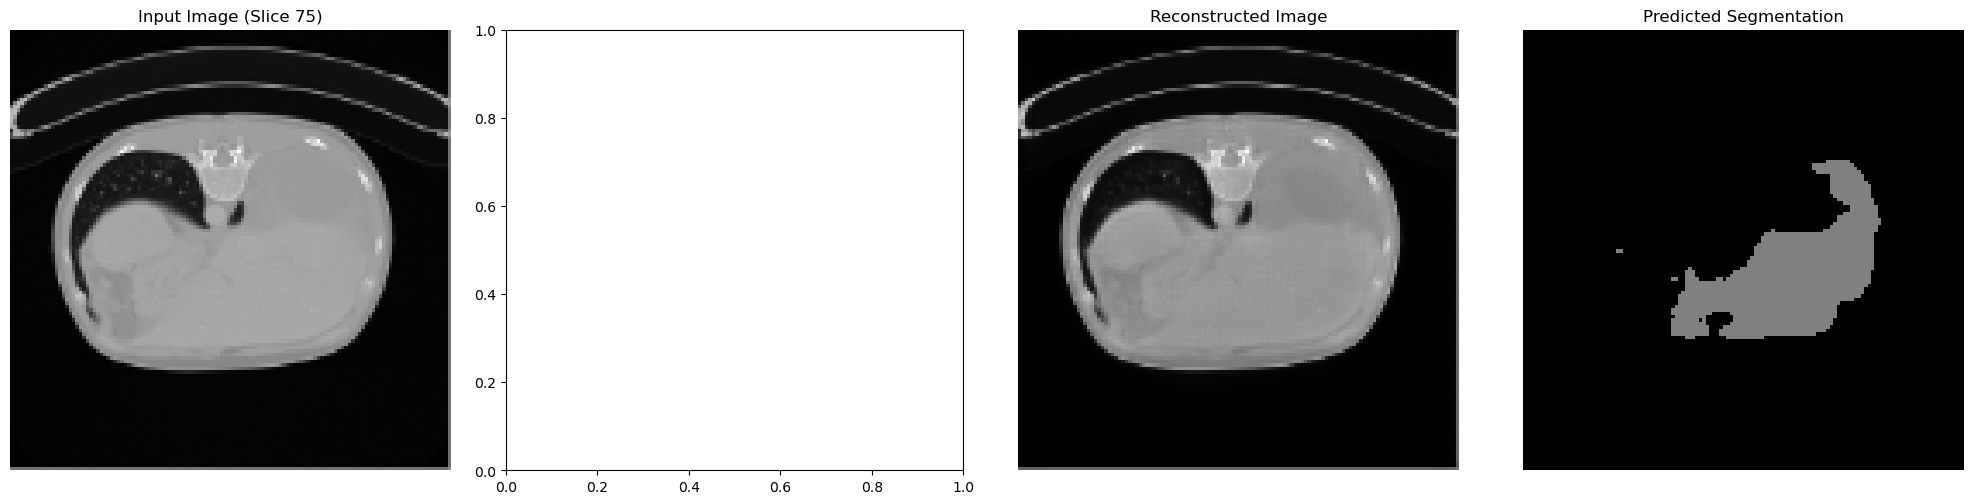

In [21]:
from func.utill import visualize_slice_no_target


visualize_slice_no_target(x_unlabeled, x_unlabeled,recon_out, seg_out, slice_idx=75)


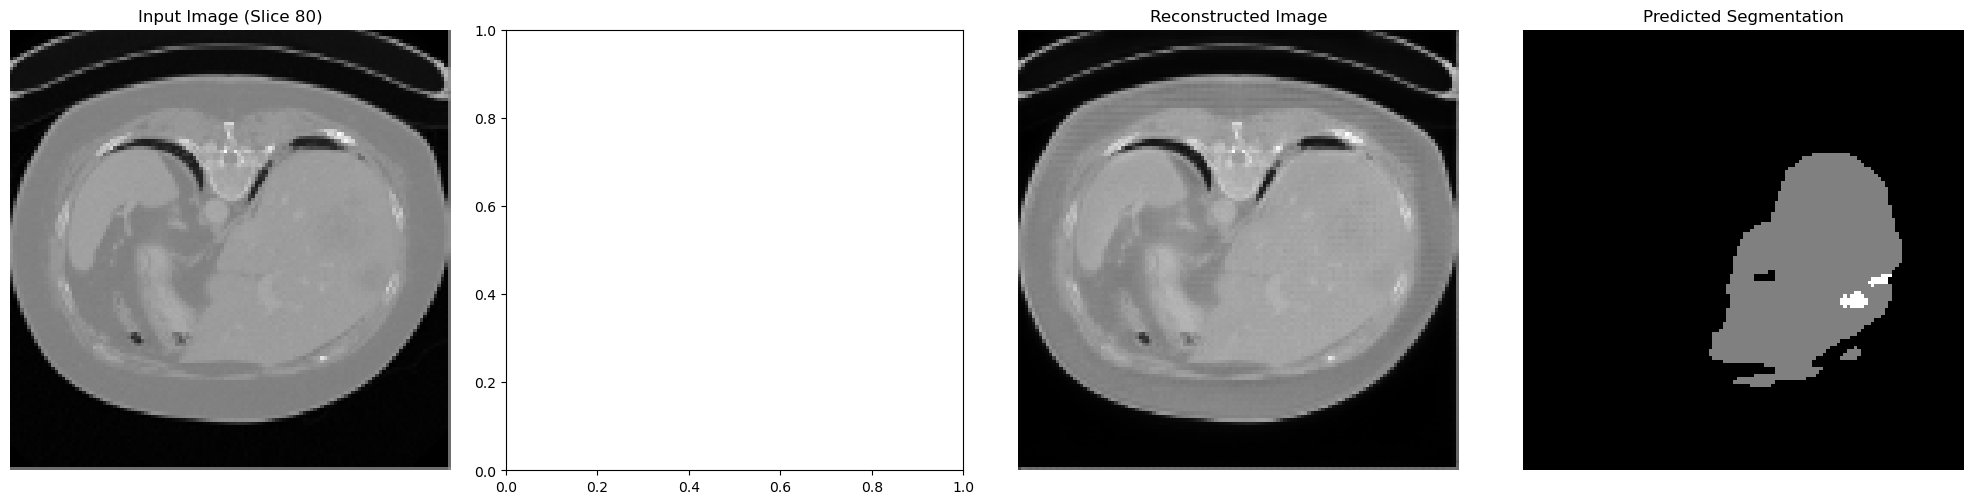

In [25]:
visualize_slice_no_target(x_unlabeled, x_unlabeled,recon_out, seg_out, slice_idx=80)